https://gist.github.com/pizlonator/cf1e72b8600b1437dda8153ea3fdb963 pizlo ssa
https://bernsteinbear.com/blog/compiler-effects/?utm_source=rss compiler effects. Interesting. An abstract domain of effects. He comments this is reminsceont of algerbaic effects. Sort of a floatibng

https://hachyderm.io/@zwarich/115217086843186859  https://theses.hal.science/tel-00007405v1 Register Pressure in Instruction Level Parallelism  https://myhsu.xyz/llvm-machine-scheduler/

https://c9x.me/compile/bib/new-c.pdf
mov(addr1,addr2,array)
store(array, addr, v)

Theory of arrays is kind of enough to do these rewrites?

seq
ForAll([insn], mov(a,b)(insn(mov(c,d))) == mov()(insn))

mov(addr1, addr2)(array)
set(a, v)(array)
& and *
*&x -> x. That's a crazy optimization
nand2tetris styel
r0 = 0
probably with strong no alias conventions. regular addresses


mov(a,b)
mov()


yoloing graphy egraph.
Is there a simpler version of the problem? Graph rewritnig examples to extract a final result form 
https://arxiv.org/pdf/1906.05170 efficient graph rewriting



One notch of internalization missing. We don't verify the compiler, but verify a particular compilation. It does make it a bit easier.

Assembly is ROM -> ROM statements

ROM is partial map of Addr -> Insn
Via hughes list trick, eparating conjunction partially pplied becomes
ROM -> ROM
asm(emp) gives back original code.

`*` vs concat
`*` just overlaps. Concat also forces exact abutment.

argmax(valid) = max(l, valid[l] == True)
I do kind of feel this could be a separation logic operator? If there is a total order on addresses. Ehh.



I'm mocking out actual x86 instructions on a fake semantics.



In [ ]:
from kdrag.all import *
State = smt.ArraySort(smt.BitVecSort(16), smt.BitVecSort(16)) # RAM
r0 = kd.define("r0", [], smt.BitVecVal(0, 16))
r1 = kd.define("r1", [], smt.BitVecVal(1, 16))
r2 = kd.define("r2", [], smt.BitVecVal(2, 16))
sp = kd.define("sp", [], smt.BitVecVal(-1, 16))
pc = kd.define("pc", [], smt.BitVecVal(-2, 16))
zf = kd.define("zf", [], smt.BitVecVal(-3, 16))

dst,src,imm = smt.BitVecs("dst src imm", 16)
st = smt.Const("st", State) # ram = smt.Const("ram", RAM)
mov = kd.define("mov", [dst,src], smt.Lambda([st], smt.Store(st, dst, st[src])))
ldi = kd.define("ldi", [dst,imm], smt.Lambda([st], smt.Store(st, dst, imm)))
cmov = kd.define("cmov", [dst,src], smt.Lambda([st], smt.If(st[sp] != 0, smt.Store(st, dst, st[src]), st)))
push = kd.define("push", [src], smt.Lambda([st], smt.Store(smt.Store(st, sp, st[sp]-1), st[sp], st[src])))
pop = kd.define("pop", [dst], smt.Lambda([st], smt.Store(smt.Store(st, dst, st[st[sp]]), sp, st[sp]+1)))
add = kd.define("add", [dst,src], smt.Lambda([st], smt.Store(st, dst, st[dst] + st[src])))
addi = kd.define("addi", [dst,imm], smt.Lambda([st], smt.Store(st, dst, st[dst] + imm)))
sub = kd.define("sub", [dst,src], smt.Lambda([st], smt.Store(st, dst, st[dst] - st[src])))
label = smt.BitVec("label", 16)
cmp = kd.define("cmp", [src1,src2], smt.Lambda([st], smt.Store(smt.Store(st, zf, smt.If(st[src1] == st[src2], smt.BitVecVal(1,16), smt.BitVecVal(0,16))), sp, st[sp]+1)))
jmp = kd.define("jmp", [label], ldi(pc, label))
je = kd.define("je", [label], smt.Lambda([st], smt.If(st[zf] != 0, ldi(pc, label)(st), addi(pc,1)(st))))
nop = kd.define("nop", [], smt.Lambda([st], st))
# havoc
reset = kd.define("reset", [], smt.Store(smt.K(smt.BitVecSort(16), smt.BitVecVal(0,16)), pc, st[pc] + 1))

def def_insn(name, args, body):
    return kd.define(name, args, smt.Lambda([st], body))
def fall_insn(name, args, body):
    return def_insn(name, args, addi(pc,1)(body))

def insn_print(insn):
    return f"{insn.decl().name()} " + ", ".join(str(a) for a in insn.children())
def insns_print(insns):
    return "\n".join([insn_print(i) for i in insns])

label = kd.define("label", [l])
def label(l, insns): # SeqSort(Insn) ? To internalize? It's a foldi
    return l, l+len(insns), smt.Lambda([rom], kd.MultiStore(rom, l, insns))
# assembly programs are kind of programs that construct the binary. Rom -> Rom statements. This is a Hughes list form of concat sequences.
def asm(roms):
    # put the pieces together, accumulate non overlap constraints / abutting constraints
    smt.And(end + 1 == start for (_, end, _), (start, _, _) in zip(roms[:-1], roms[1:])), 
    return smt.Distinct([rom[0] for rom in roms]), functools.reduce(lambda r1,r2: kd.MultiStore(r1, *[(k, v) for k,v in r2.items()]), roms, initial=smt.K(smt.BitVecSort(16), smt.K(smt.BitVecSort(16), smt.BitVecVal(0,16))))

#ret
#halt = kd.define("halt", [], ldi(pc, smt.BitVecVal(-1,16)))
#loop

seq = kd.define("seq", [st1,st2], smt.Lambda([st], st2(st1(st))))
kd.notation.matmul.register(Insn, seq) # Uh. actually I might already have this in fun?
seq_assoc = (i @ j) @ k == i @ (j @ k)




[
 mov(r0,r1),
 add(r0,r1),
 sub(r1,r0)
 ]

import functools
def prog(insns : Sequence[smt.ExprRef]): # call this seq?
    return smt.Lambda([st], functools.reduce(lambda st,insn: insn(st), insns, initial=st))

def fall(insn):
    return prog([addi(pc,1), insn])

ROM = smt.ArraySort(smt.BitVecSort(16), smt.ArraySort(State, State))
def fetch(st, rom):
    return rom[st[pc]]

def trans(st,st1):
    return st1 == fetch(st, rom)(st)





[mov(r0, r1), add(r0, r1), sub(r1, r0)]

It possibly is nice to know that registers don't alias.
regfile and ram. But then need to have state and define regs.



In [ ]:
Reg = kd.datatype("type Reg = R0 | R1 | R2 | SP | PC")
RegFile = smt.ArraySort(Reg, smt.BitVecSort(16))
RAM = smt.ArraySort(smt.BitVecSort(16), smt.BitVecSort(16))
#Rom = smt.ArraySort(smt.BitVecSort(16), smt.ArraySort(State, State))
State = kd.datatype("type State = State { regs: RegFile, ram: Ram }")
Insn = smt.ArraySort(State, State)
ROM = smt.ArraySort(smt.BitVecSort(16), Insn)

Stack machine. Calculating compilers
 HACK VM

Forth, https://www.reddit.com/r/Forth/
 CAM
wasm



In [ ]:
Stack = smt.SeqSort(smt.BitVecSort(16)) # Or array + sp?
st = smt.Const("st", Stack)
imm = smt.BitVec("imm", 16)
push = kd.define("push", [imm], smt.Lambda([st], smt.Concat(smt.Unit(imm), st)))
pop = kd.define("pop", [], smt.Lambda([st], smt.SubSeq(0, smt.Length(st)-1, st)))
add = kd.define("add", [], smt.Lambda([st], smt.Concat(smt.Unit(st[0] + st[1]), smt.SubSeq(2, smt.Length(st)-2, st))))
sub = kd.define("sub", [], smt.Lambda([st], smt.Concat(smt.Unit(st[1] - st[0]), smt.SubSeq(2, smt.Length(st)-2, st))))
dup = kd.define("dup", [], smt.Lambda([st], smt.Concat(smt.Unit(st[0]), st)))

#State = kd.datatype("type State = State { ram: Ram, stack: Stack }")

functions as blocks
Expand into 3ac lists.

theorem:
block(x,y) == exec(state(rdi=x, rsi=y), insns)


In [ ]:
from kdrag.all import *
x,y,z = smt.BitVecs('x y z', 64)
ret = kd.define("ret", [x], x)
#block2 = kd.define("block2", [x], ret(x*2))
#block1 = kd.define("block1", [x], block2(x+1))
block1 = smt.Function("block1", smt.BitVecSort(64), smt.BitVecSort(64))
block1 = kd.define("block1", [x], smt.If(smt.UGT(x, 0), block1(x-1), x))

kd.rewrite.full_simp(block1(10))
kd.rewrite.full_simp(block1(25))

blocks = [
    block1
]


0

In [ ]:
import ast
ex1 = """
i = 10
while i > 0:
    i -= 1
"""
#print(ast.dump(ast.parse(ex1), indent=4))

def gendef(args, body):
    f = FreshFunction()
    return kd.define(f.name(), args, body)

def blockify(stmt, cb):
    #todo = module.body
    #while todo:
    #    stmt = todo.pop(0)
    #    case ast.While(test, body, orelse):
    
    match stmt:
        case ast.While(test, body, orelse):
            print("WHILE", ast.dump(test))
            for b in body:
                blockify(b)
        case ast.Assign(targets, value):
            print("ASSIGN", ast.dump(targets), ast.dump(value))
        case _:
            print("OTHER", ast.dump(stmt))
blockify(ast.parse(ex1))

AttributeError: 'str' object has no attribute 'body'

# older

Bril
llvm
xdsl

nanopass

vectorization

mini python 

https://github.com/IUCompilerCourse/Essentials-of-Compilation
https://github.com/IUCompilerCourse/python-student-support-code

https://github.com/IUCompilerCourse/python-student-support-code/blob/main/interp_x86/parser_x86.py


https://github.com/cslarsen/minijit
https://github.com/zserge/tinylangs/blob/main/asm.py
https://github.com/benhoyt/pyast64  https://benhoyt.com/writings/pyast64/
https://github.com/Maratyszcza/PeachPy
https://github.com/ssloy/tinycompiler

https://news.ycombinator.com/item?id=14644576

https://gitlab.com/tsoding/porth https://www.youtube.com/watch?v=QlKSCn-Al6Q&ab_channel=TsodingDaily


Some mix of meta and internalized

https://github.com/slothy-optimizer/slothy/ https://eprint.iacr.org/2022/1303

In [17]:
from kdrag.all import *
BV64 = smt.BitVecSort(64)
getarg = smt.Function("getarg", smt.IntSort(), BV64)

def remove_complex_operands(e : smt.ExprRef):
    todo = [e]
    prog = []
    while todo:
        e = todo.pop()
        prog.append(e)
        if isinstance(e, smt.BitVecNumRef):
            continue
        if smt.is_app(e):
            if e.decl() != getarg:
                assert e.num_args() <= 2
                todo.extend(e.children())
        else:
            raise ValueError("Expected an application, got: ", e)
    return list(reversed(prog))
prog = getarg(0) + 42 - getarg(1)
prog1 = remove_complex_operands(prog)

In [ ]:
def remove_complex_correct(prog0, prog1):
    # There's nothing much to say here.
    pass

In [ ]:
movq = smt.Function("movq", BV64, BV64)
subq = smt.Function("subq", BV64, BV64, BV64)
addq = smt.Function("addq", BV64, BV64, BV64)
Reg = kd.Enum("Reg", ["RAX", "RBX", "RCX", "RDX", "RSI", "RDI", "RSP", "RBP", "R8", "R9", "R10", "R11", "R12", "R13", "R14", "R15"])
Insn = kd.Enum("Insn", ["movq", "addq", "subq"])

def instruction_select(prog : list[smt.ExprRef]):
    res = []

    for expr in prog:
        if isinstance(expr, smt.BitVecNumRef):
            continue
        else:
            match expr.decl().name():
                case "getarg":
                    i = expr.arg(0)
                    assert isinstance(i, smt.IntNumRef)
                    reg = [Reg.RDI, Reg.RSI, Reg.RDX, Reg.RCX, Reg.R8, Reg.R9][i.as_long()]
                    res += [(movq, reg, expr)]
                case "bvadd":
                    arg1,arg2 = expr.children()
                    res += [(movq, arg1, Reg.RAX),
                            (addq, arg2, Reg.RAX),
                            (movq, Reg.RAX, expr)]
                case "bvsub":
                    arg1,arg2 = expr.children()
                    res += [(movq, arg1, Reg.RAX),
                            (subq, arg2, Reg.RAX),
                            (movq, Reg.RAX, expr)]
                
                case _:
                    raise ValueError("Unexpected expression in instruction selection: ", expr)
    return res


prog2 = instruction_select(prog1)
prog2 

[(movq, RDI, getarg(0)),
 (movq, getarg(0), RAX),
 (addq, 42, RAX),
 (movq, RAX, getarg(0) + 42),
 (movq, RSI, getarg(1)),
 (movq, getarg(0) + 42, RAX),
 (subq, getarg(1), RAX),
 (movq, RAX, getarg(0) + 42 - getarg(1))]

In [ ]:
rsp = smt.BitVec("rsp", 64)

def assign_home(prog):
    res = []
    stack = {}
    for stmt in prog:
        match stmt:
            case (op, arg1, arg2):
                print(f"{op} {arg1} {arg2}")
                if arg1.sort() == BV64:
                    if arg1 not in stack:
                        stack[arg1] = rsp + len(stack) * 8
                res.append((op, stack[arg1], stack[arg2]))
            case _:
                raise ValueError("Unexpected statement in assignment: ", stmt)
    return res
assign_home(prog2)

movq RDI getarg(0)
movq getarg(0) RAX
addq 42 RAX
movq RAX getarg(0) + 42
movq RSI getarg(1)
movq getarg(0) + 42 RAX
subq getarg(1) RAX
movq RAX getarg(0) + 42 - getarg(1)


In [ ]:
    env = {}
    regfile = smt.Const("undefined", Regfile)
regfile[[RDI, RDX][i.as_long()]]
Regfile = smt.ArraySort(Reg, BV64)

mov_to_rax = smt.Function("movq", BV64, Regfile, Regfile)
read_rax = smt.Function("read_rax", Regfile, BV64)
add_rax = smt.Function("add_rax", BV64, Regfile, Regfile)




In [ ]:
Stmt = smt.ArraySort(State, State)
RR = smt.Function("RR", Insn, Reg,   Reg,       State, State) # Reg Reg insn
smt.Function("MR", Insn, Reg, BV64,  Reg,  State, State) # Mem Reg insn
smt.Function("IR", Insn, BV64,   Reg,      State, State) # Imm Reg insn
smt.Function("RM", Insn, Reg,  Reg, BV64,  State, State) # Reg Reg insn

def from_tup(insn):
    insn, op1, op2 = insn
    s1,s2 = op1.sort(), op2.sort()
    if s1 == Reg and s2 == Reg:
        return RR(insn, op1, op2)
    elif s1 == Reg and s2 == BV64:
        return MR(insn, op1, op2)
    elif s1 == BV64 and s2 == Reg:
        return RM(insn, op1, op2)



In [ ]:
Stack = smt.ArraySort(smt.BitVecSort(8), BV64)
Reg = kd.Enum("Reg", ["RAX", "RBX", "RCX", "RDX", "RSI", "RDI", "RSP", "RBP"])
Regfile = smt.ArraySort(Reg, BV64)
movqrr = smt.Function("movqrr", Reg, Reg,  Regfile, Regfile)
movqlr = smt.Function("movqlr", BV64, Reg, Regfile, Regfile)
movqrl = smt.Function("movqrl", BV64, Reg, Regfile, Regfile)
movqsr = smt.Function("movqsr", Reg, Stack, Regfile, Regfile)
movqrs = smt.Function("movqrs", Stack, Reg, Regfile, Stack)

State = kd.Struct("x86State", ("regs", Regfile), ("stack", Stack))


TypeError: Enum() takes 2 positional arguments but 9 were given

target interpreter



In [ ]:
%%file /tmp/test.S

.globl mytest
mytest:
    mov $42, %rax
    ret

In [ ]:
!gcc -c -fPIC -o /tmp/test.o /tmp/test.S && ld -shared -o /tmp/test2.so /tmp/test.o && objdump -d /tmp/test.so

In [ ]:
import cffi

ffi = cffi.FFI()
ffi.cdef("""uint64_t mytest();""")
lib = ffi.dlopen("/tmp/test2.so")
dir(lib)
print(lib.mytest())
del lib

def 

# Interactive Assembly





In [1]:
%%file /tmp/myfunc.s

.macro kd_assert label smt_expr
\label:
.endm

.macro kd_pre label smt_expr
.endm


.macro kd_post label smt_expr
.endm

# kd_entry?


# myfunc.s
.globl myfunc

.text
myfunc:
    kd_pre myfunc "(assert true)"
    kd_post myfunc "(assert (= RAX (_ bv42 64)))"
    movq $42, %rax
    kd_assert func_end "(assert (= RAX (_ bv42 64)))"
    ret


Writing /tmp/myfunc.s


In [2]:
! as -o /tmp/myfunc.o /tmp/myfunc.s && objdump -d /tmp/myfunc.o


/tmp/myfunc.o:     file format elf64-x86-64


Disassembly of section .text:

0000000000000000 <myfunc>:
   0:	48 c7 c0 2a 00 00 00 	mov    $0x2a,%rax

0000000000000007 <func_end>:
   7:	c3                   	ret


In [3]:
import re
from kdrag.all import *
def find_kdasserts(lines):
    pattern = re.compile(r'^\s*kd_assert\s+(\w+)\s+"([^"]+)"\s*$')
    results = []
    for lineno, line in enumerate(lines, 1):
        match = pattern.match(line)
        if match:
            label, smt_expr = match.groups()
            #RAX = smt.BitVec("RAX", 64)
            #smt_expr = smt.parse_smt2_string(smt_expr, decls={"RAX": RAX})
            results.append((lineno, label, smt_expr))
    return results

# Example usage:

with open("/tmp/myfunc.s") as f:
    lines = f.readlines()
    asserts = find_kdasserts(lines)
    print(asserts)


[(24, 'func_end', '(assert (= RAX (_ bv42 64)))')]


In [4]:
def verify(asm_file : str):
    with open(asm_file) as f:
        lines = f.readlines()
        asserts = find_kdasserts(lines)
    subprocess.run(["as", "-o", "/tmp/verify.o", asm_file], check=True)
    ctx = pcode.BinaryContext("/tmp/verify.o")
    
    
    


In [5]:
import kdrag.contrib.pcode as pcode
from kdrag.all import *
ctx = pcode.BinaryContext("/tmp/myfunc.o")
#ctx.loader.symbols
for (lineno, label, smt_expr) in asserts:
    sym = ctx.loader.find_symbol(label)
    print(sym.name, sym.rebased_addr)

myfunc_sym = ctx.loader.find_symbol("myfunc")
mem = pcode.MemState.Const("mem")
symstates = ctx.sym_execute(mem, myfunc_sym.rebased_addr, max_insns=1, verbose=True)
smt.simplify(symstates[0].memstate.getvalue(ctx.ctx.registers["RAX"]))

mem = symstates[0].memstate
#{smt.BitVec(name, vnode.size*8) : smt.simplify(mem.getvalue(vnode)) for name,vnode in ctx.ctx.registers.items()}

def get_reg(ctx : pcode.BinaryContext, mem : pcode.MemState, name : str):
    vnode = ctx.ctx.registers[name]
    return smt.simplify(mem.getvalue(vnode))

print(get_reg(ctx, mem, "RAX"))

decls = [smt.BitVec(name, vnode.size * 8) for name, vnode in ctx.ctx.registers.items()]
#decls.append(smt.Array("mem", smt.BitVecSort(64), smt.BitVecSort(8)))
# select32
# select64
# old_mem? ghost state?  kd_ghost "(define)"    kd_assign  ghostname "smt expr"
# yikes.

decls # decls is for parsing 
for (lineno, label, smt_expr) in asserts:
    print(smt.parse_smt2_string(smt_expr, decls={decl.decl().name(): decl for decl in decls}))

def addr_assert_expr(ctx : pcode.BinaryContext, asserts) -> dict[int, smt.ExprRef]:
    decls = [smt.BitVec(name, vnode.size * 8) for name, vnode in ctx.ctx.registers.items()]
    decls.append(smt.Array("mem", smt.BitVecSort(64), smt.BitVecSort(8)))
    decls = {decl.decl().name(): decl for decl in decls}
    return {
            ctx.loader.find_symbol(label).rebased_addr:
            smt.parse_smt2_string(smt_expr, decls=decls)[0] for lineno, label, smt_expr in asserts
            }

def eval_smt(smt_expr : smt.ExprRef, ctx : pcode.BinaryContext, mem : pcode.MemState):
    substs = [(decl, get_reg(ctx, mem, decl.decl().name())) for decl in decls]
    for v,v1 in substs:
        assert v.sort() == v1.sort(), f"Sort mismatch: {v.sort()} != {v1.sort()}"
        assert isinstance(v, smt.ExprRef), f"Expected smt.ExprRef, got {type(v)}: {v}"
        assert isinstance(v1, smt.ExprRef), f"Expected smt.ExprRef, got {type(v1)}: {v1}"
    # TODO: add in mem also
    # TODO: also probably should pull instead of push all subtitutions.
    #print(substs)
    print(smt_expr.sort())
    return smt.substitute(smt_expr, *substs)

addr_assert_expr(ctx, asserts)

func_end 4194311
Executing 0x400000/7: MOV RAX,0x2a at (4194304, 0)
Executing 0x400000/7: MOV RAX,0x2a at (4194304, 1)
42
[RAX == 42]


{4194311: RAX == 42}

In [6]:
def run_all_paths(ctx, entries=[], exits=[], asserts={}):
    print(asserts)
    todo = []
    for entry in entries:
        todo.append(pcode.SimState(mem, (entry, 0), []))
    while todo:
        state = todo.pop()
        print(state.pc, exits)
        addr, pc = state.pc
        assert pc == 0
        if addr in asserts:
            print("assert reached", addr, asserts[addr])
            print(eval_smt(asserts[addr], ctx, state.memstate))
            print(kd.prove(smt.Implies(smt.And(*state.path_cond), eval_smt(asserts[addr], ctx, state.memstate))))
            # maybe prove form (state == current state => assert_expr) 
        if addr in exits:
            print("exit reached")
            continue
        else:
            todo.extend(ctx.sym_execute(mem, addr, max_insns=1, verbose=True))

run_all_paths(ctx, entries=[myfunc_sym.rebased_addr], exits=[myfunc_sym.rebased_addr + 7], asserts=addr_assert_expr(ctx, asserts))

{4194311: RAX == 42}
(4194304, 0) [4194311]
Executing 0x400000/7: MOV RAX,0x2a at (4194304, 0)
Executing 0x400000/7: MOV RAX,0x2a at (4194304, 1)
(4194311, 0) [4194311]
assert reached 4194311 RAX == 42
Bool
42 == 42
Bool
|- Implies(And, 42 == 42)
exit reached


Use angr to get cfg
Symexec blocks into semantics.

How does angr do translation between registers and stuff

Difference between an assertion and a cut / invariant. (?)


Ideas: embed python script or bash commands to grep manuals for assumptions.
Embed Verilog assertions? Read from svd files?
Remember that idea about keeping docs in sync. A third yaml file?


Reasoning about interrupts. Interrupt prempting interrupts. Not noticing you need to lock critical sections. How to detect?
Yikes.


Am I insane? What is really better about this than other systems. Is there some off the shlef binary verifier i could use?





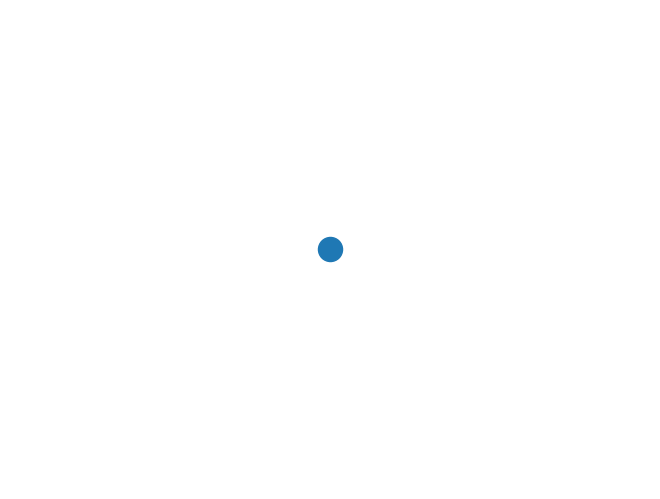

In [18]:
import networkx as nx
nx.draw(cfg.model.graph)
#cfg.dbg_draw()
f.dbg_draw("/tmp/fdbg.png")

In [19]:
! open /tmp/fdbg.png

{4194311: [RAX == 42]}
(4194304, 0) [4194311]
Executing 0x400000/7: MOV RAX,0x2a at (4194304, 0)
Executing 0x400000/7: MOV RAX,0x2a at (4194304, 1)
(4194311, 0) [4194311]
assert reached 4194311 [RAX == 42]


Z3Exception: Z3 expression expected

In [14]:
assert_dict = {
    ctx.loader.find_symbol(label) : smt_expr for lineno, label, smt_expr in asserts }
assert_dict

{<Symbol "func_end" in myfunc.o at 0x400007>: '(assert (= RAX (_ bv42 64)))'}

No wait. Why bother going through angr?

VCs append or just discharge it.

On the other hand, if I just used angr's symbolic executor I could still discharge the user experience of assembly assertions.
Maybe smtlib wouldn't be the lowest hanging fruit anymore.
Just something evaled

Or even AFL or some other thing


In [ ]:

asserts = {}
assumes = {}
invariants = {} # global invariants and local tagged invariants.
# maybe invariants and cuts should be distinguished?
exits = {}
mem = pcode.MemState.Const("mem")
entries = {} # path_cond0 = preconds
todo = [pcode.SimState(mem, (myfunc_sym.rebased_addr, 0), [])]  # (addr, pc)
VCs = []
seen = set()
while todo:
    mem, pc, path_cond = todo.pop()
    assert pc[1] == 0
    addr = pc[0]
    if addr in asserts:
        VCs.append((path_cond, eval_smt(asserts[addr], ctx, mem)))
        # possibly add to path_cond?
        # kd.prove(smt.Implies(smt.And(path_cond), eval_smt(asserts[addr], ctx, mem)))
    if addr in assumes:
        path_cond = path_cond + [eval_smt(assumes[addr], ctx, mem)]
    elif addr in invariants:
        # If invariant, make sure we the invariant is satisfied when we reach it
        VCs.append((path_cond, eval_smt(invariants[addr], ctx, mem)))
        if addr in seen: # already started this invariant starting point
            continue
        else:
            # start new search with only invariant as assumption about state
            mem = pcode.MemState.Const("mem")
            todo.append(pcode.SimState(mem, (addr, 0), [eval_smt(invariants[addr], ctx, mem)]))
            seen.add(addr)
            continue
    elif addr in exits:
        # add function postcondition to VCs
        continue
    else:
        # execute the actual instruction
        todo.extend(ctx.sym_execute(mem, addr, max_insns=1, verbose=True))


In [ ]:
import angr
proj = angr.Project("/tmp/myfunc.o", auto_load_libs=False)
cfg = proj.analyses.CFGFast()
print("This is the graph:", cfg.model.graph)
f = cfg.kb.functions[myfunc_sym.rebased_addr]
blk = list(f.blocks)[0] # transition _Graph, block_addrs, 
blk.instructions
blk.addr

asserts = {} # addr -> smt_expr
blks = []
VCs = []
for blk in f.blocks:
    blk.pp()
    mem = pcode.MemState.Const("mem")
    for addr in blk.instruction_addrs:
        if addr in breakpoints:
            VCs.append(eval_smt(asserts[addr], ctx, mem))
        print(f"Breakpoint at {hex(addr)}")
        breakpoint = [addr]
        break
        res = ctx.sym_execute(mem, blk.addr, max_insns=blk.instructions-1, verbose=True)
        assert len(res) == 1
        mem = res[0]
    print(res)
    blks.append((blk, res))
    


blk.instruction_addrs

#cfg.kb.functions[sym.rebased_addr]

This is the graph: DiGraph with 1 nodes and 0 edges
        myfunc:
400000  mov     rax, 0x2a
        func_end:
400007  ret     
Executing 0x400000/7: MOV RAX,0x2a at (4194304, 0)
Executing 0x400000/7: MOV RAX,0x2a at (4194304, 1)
[SimState(memstate=MemState(mem=MemState(ram(mem),
         Store(Store(Store(Store(Store(Store(Store(Store(register(mem),
                                        0 + 0,
                                        Extract(7, 0, 42)),
                                        0 + 1,
                                        Extract(15, 8, 42)),
                                        0 + 2,
                                        Extract(23, 16, 42)),
                                       0 + 3,
                                       Extract(31, 24, 42)),
                                 0 + 4,
                                 Extract(39, 32, 42)),
                           0 + 5,
                           Extract(47, 40, 42)),
                     0 + 6,
         

(4194304, 4194311)

Ok so somehow I need to assert at positions inside the code.
angr symbolic exec has 


In [27]:
dir(blk)

['BLOCK_MAX_SIZE',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_bytes',
 '_capstone',
 '_collect_data_refs',
 '_const_prop',
 '_cross_insn_opt',
 '_disassembly',
 '_get_cmsg',
 '_initial_regs',
 '_instruction_addrs',
 '_instructions',
 '_load_from_ro_regions',
 '_opt_level',
 '_parse_vex_info',
 '_project',
 '_strict_block_end',
 '_using_pcode_engine',
 '_vex',
 '_vex_engine',
 '_vex_nostmt',
 'addr',
 'arch',
 'bytes',
 'capstone',
 'codenode',
 'disassembly',
 'instruction_addrs',
 'instructions',
 'parse',
 'parse_from_cmessage',
 'pp',
 'reset_initial_regs',
 'serialize',
 'serialize_to_cmessage',
 'set_initial_regs',
 'size',
 'thumb',
 've

def get_asserts(lines):
    pattern = r'kdassert\s+(\w+)\s+"([^"]+)"'
    matches = re.findall(pattern, text)
    return matches:


with open("myfunc.s") as f:
    get_asserts(f.readlines())